In [1]:
import h5py
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import itertools 
import pyts
from pyts.approximation import PiecewiseAggregateApproximation

from sklearn.utils import class_weight

import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import Convolution2D,Conv2D, Dense,Dropout, Flatten, Activation, MaxPooling2D, Input, Conv1D, GlobalAveragePooling1D, TimeDistributed, GRU, LSTM

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')

try:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except RuntimeError as e:
    print(e)

2022-02-11 22:55:57.917086: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0


2.5.0
Num GPUs Available:  1


2022-02-11 22:55:59.459858: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcuda.so.1
2022-02-11 22:55:59.507063: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-02-11 22:55:59.507118: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2022-02-11 22:55:59.511613: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2022-02-11 22:55:59.511676: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11
2022-02-11 22:55:59.513488: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library li

In [2]:
from os import environ
dataset = environ['dataset']
print(dataset)

eco_gen_GASF_13m_100S5X11A38085_R82_80-20


In [3]:
#my defs 
from modules.models import  LSTM_3D_V56, CNN_V56,LSTM_BI_V56
from modules.tools import my_print, plot_confusion_matrix_norm, get_data,get_data_split, evaluate_model, create_tl_model
from modules.HDF5ImageGenerator import HDF5ImageGenerator

In [4]:
#LOAD DATASET
#file_name = "ukdale_gen_GASF_13m_100S5X12A54480"
#file_name = "refit_gen_GASF_13m_100S5X_15A166006"
file_name = "refit_gen_GASF_13m_100S5X_15A166006_R42-80-20"
#file_name = "refit_gen_GASF_13m_100S5X_15A166006_R42_80-20"
file_name = "refit_gen_GASF_60m_300S0X_15A157030N_R12_80-20-V1"
file_name = environ["dataset"]
#read the file
path = str(pathlib.Path().resolve())

path_data = f"{path}""/data/"f"{file_name}""/"f"{file_name}"".hdf5"

file = h5py.File(path_data,"r+")

In [5]:
x_test,y_test,d_class_weights,num_of_classes,appliances = get_data(file)

['HEKA', 'fridge/freezer', 'HTPC', 'audio system', 'broadband router', 'coffee maker', 'computer', 'lamp', 'laptop computer', 'microwave', 'washing machine']
{0: 4.72665218740304, 1: 0.17788312772578393, 2: 0.5904536733784229, 3: 2.508893280632411, 4: 2.2035148622260796, 5: 10.612330198537094, 6: 0.8248416265092858, 7: 3.213246150601139, 8: 1.347843397478434, 9: 5.1869254341164455, 10: 14.655122655122655}
 
Tests 
HEKA test: 146 train: 586
fridge/freezer test: 3893 train: 15571
HTPC test: 1173 train: 4691
audio system test: 276 train: 1104
broadband router test: 314 train: 1257
coffee maker test: 65 train: 261
computer test: 839 train: 3358
lamp test: 216 train: 862
laptop computer test: 514 train: 2055
microwave test: 134 train: 534
washing machine test: 47 train: 189


In [6]:
def select_model(learn_type):
    
    if learn_type == "CNN":
        model = CNN_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    if learn_type == "LSTM":
        model = LSTM_3D_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    if learn_type == "BI_LSTM":
        model = LSTM_BI_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    return model
              

In [7]:
path_save = path+'/experiment_automation/output/'+environ['learn_type']+'/'+dataset.split("_")[0]+"/"+environ['train_type']+"/"+dataset.split("_")[0]+"_"+environ['seed']+"_"+environ['tl_datasets']
path_save_nb = path_save+"_out.ipynb"
path_save_log = path_save+"_out_log2.txt"

In [8]:
from keras.callbacks import LambdaCallback
#path_log= path+'/experiment_automation/output/'+environ['learn_type']+'/'+dataset.split("_")[0]+"/"+environ['train_type']+"/"+dataset.split("_")[0]+"_"+environ['seed']+"_"+environ['tl_datasets']+"_log.txt"
txt_log = open(path_save+"_log.txt", mode='wt', buffering=1)
txt_log.write("file created! \n")

save_op_callback = LambdaCallback(
  on_epoch_end = lambda epoch, logs: txt_log.write(
    str({'epoch': epoch, 'loss': logs['loss'],'acc': logs['accuracy']}) + '\n'),
                                                           
)

In [9]:
print(path_save_nb)

/workspace/notebooks/experiment_automation/output/BI_LSTM/eco/TL/eco_82_refit, iawe, redd, ukdale_out.ipynb


In [10]:
# rm $path_save_log

In [11]:
# %%capture cap 

# with open(path_save_log,"wt") as f:
#     f.write(cap.stdout)
    
# print("out capture..")

In [12]:
# %%capture cap --no-stderr


if environ['train_type'] == "BB":

    #define generator
    train_gen = HDF5ImageGenerator(
        src= path_data,
        X_key="data/train/gaf",
        y_key="labels/train/gaf",
        classes_key="appliances/classes",
        labels_encoding="hot",
        shuffle=True,
        batch_size=int(environ['batch_size']),
        num_classes=num_of_classes,
        mode="train",
        )
    
    model = select_model(environ['learn_type'])
    
    txt_log.write("fitting BB model: \n")
    
    model.fit(
        train_gen,
        verbose=2,
        epochs=int(environ['epochs']),
        class_weight=d_class_weights,
        callbacks = [save_op_callback],
    )
    
    txt_log.write("finished fitting BB model: \n")

    evaluate_model(model,x_test,y_test,appliances)
    
    if environ['save_model']=="True":

        path_model_save = path+"/models/"+environ['learn_type']+"/"+dataset.split("_")[0]+"_"+dataset.split("_R")[1][0:2]
        model.save(path_model_save)
        txt_log.write("model saved to:"+"/models/"+environ['learn_type']+"/"+dataset.split("_")[0]+"_"+dataset.split("_R")[1][0:2]+" \n")
        
        
# with open(path_save+"_out_log.txt" as f:
#     f.write(cap.stdout)


In [13]:
#model = keras.models.load_model(path_model1)
# model_used = model

In [14]:
# evaluate_model(model,x_test,y_test,appliances)

using dataset data eco training on model refit seed 82
reading data, printing stats: 
['HEKA', 'fridge/freezer', 'HTPC', 'audio system', 'broadband router', 'coffee maker', 'computer', 'lamp', 'laptop computer', 'microwave', 'washing machine']
{0: 4.72665218740304, 1: 0.17788312772578393, 2: 0.5904536733784229, 3: 2.508893280632411, 4: 2.2035148622260796, 5: 10.612330198537094, 6: 0.8248416265092858, 7: 3.213246150601139, 8: 1.347843397478434, 9: 5.1869254341164455, 10: 14.655122655122655}
 
Tests 
HEKA test: 146 train: 586
fridge/freezer test: 3893 train: 15571
HTPC test: 1173 train: 4691
audio system test: 276 train: 1104
broadband router test: 314 train: 1257
coffee maker test: 65 train: 261
computer test: 839 train: 3358
lamp test: 216 train: 862
laptop computer test: 514 train: 2055
microwave test: 134 train: 534
washing machine test: 47 train: 189
loading model
compling TL model..


2022-02-11 22:56:01.553438: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-02-11 22:56:01.553768: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1872] Adding visible gpu devices: 0
2022-02-11 22:56:01.553819: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2022-02-11 22:56:01.916918: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-02-11 22:56:01.916955: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1264]      0 
2022-02-11 22:56:01.916961: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1277] 0:   N 
2022-02-11 22:56:01.917518: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1418] Created TensorFlow device 

Normal way
[0 1 2 3 4 5 6 7 8 9]
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
2022-02-11 22:56:09.739057: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-11 22:56:09.756610: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3299990000 Hz


Epoch 1/50


2022-02-11 22:56:13.205257: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudnn.so.8
2022-02-11 22:56:13.668399: I tensorflow/stream_executor/cuda/cuda_dnn.cc:380] Loaded cuDNN version 8202
2022-02-11 22:56:14.188282: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2022-02-11 22:56:14.607541: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11


953/953 - 24s - loss: 0.8585 - accuracy: 0.6546
Epoch 2/50
953/953 - 23s - loss: 0.6135 - accuracy: 0.7260
Epoch 3/50
953/953 - 23s - loss: 0.5722 - accuracy: 0.7402
Epoch 4/50
953/953 - 23s - loss: 0.5413 - accuracy: 0.7527
Epoch 5/50
953/953 - 23s - loss: 0.5407 - accuracy: 0.7578
Epoch 6/50
953/953 - 23s - loss: 0.5169 - accuracy: 0.7629
Epoch 7/50
953/953 - 23s - loss: 0.5089 - accuracy: 0.7631
Epoch 8/50
953/953 - 23s - loss: 0.5019 - accuracy: 0.7662
Epoch 9/50
953/953 - 23s - loss: 0.4954 - accuracy: 0.7712
Epoch 10/50
953/953 - 24s - loss: 0.4926 - accuracy: 0.7727
Epoch 11/50
953/953 - 22s - loss: 0.4914 - accuracy: 0.7729
Epoch 12/50
953/953 - 23s - loss: 0.4775 - accuracy: 0.7761
Epoch 13/50
953/953 - 22s - loss: 0.4777 - accuracy: 0.7758
Epoch 14/50
953/953 - 23s - loss: 0.4724 - accuracy: 0.7802
Epoch 15/50
953/953 - 22s - loss: 0.4782 - accuracy: 0.7826
Epoch 16/50
953/953 - 23s - loss: 0.4701 - accuracy: 0.7824
Epoch 17/50
953/953 - 23s - loss: 0.4617 - accuracy: 0.7802


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Normal way
[0 1 2 3 4 5 6 7 8 9]
Epoch 1/50
953/953 - 22s - loss: 1.4548 - accuracy: 0.4468
Epoch 2/50
953/953 - 23s - loss: 1.1356 - accuracy: 0.4954
Epoch 3/50
953/953 - 23s - loss: 1.0413 - accuracy: 0.5188
Epoch 4/50
953/953 - 23s - loss: 1.0042 - accuracy: 0.5333
Epoch 5/50
953/953 - 23s - loss: 1.0028 - accuracy: 0.5454
Epoch 6/50
953/953 - 22s - loss: 0.9553 - accuracy: 0.5704
Epoch 7/50
953/953 - 23s - loss: 0.9435 - accuracy: 0.5678
Epoch 8/50
953/953 - 22s - loss: 0.9265 - accuracy: 0.5756
Epoch 9/50
953/953 - 23s - loss: 0.9146 - accuracy: 0.5853
Epoch 10/50
953/953 - 22s - loss: 0.8989 - accuracy: 0.5884
Epoch 11/50
953/953 - 22s - loss: 0.9008 - accuracy: 0.5898
Epoch 12/50
953/953 - 23s - loss: 0.8948 - accuracy: 0.5953
Epoch 13/50
953/953 - 23s - loss: 0.8766 - accuracy: 0.6036
Epoch 14/50
953/953 - 22s - loss: 0.8585 - accuracy: 0.5977
Epoch 15/50
953/953 - 22s - loss: 0.8629 - accuracy: 0.6068
Epoch 16/50
953/953 - 22s - loss: 0.8582 - accuracy: 0.6054
Epoch 17/50
953/

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Normal way
[0 1 2 3 4 5 6 7 8 9]
Epoch 1/50
953/953 - 22s - loss: 1.1458 - accuracy: 0.5846
Epoch 2/50
953/953 - 23s - loss: 0.8606 - accuracy: 0.6474
Epoch 3/50
953/953 - 22s - loss: 0.8018 - accuracy: 0.6700
Epoch 4/50
953/953 - 22s - loss: 0.7705 - accuracy: 0.6798
Epoch 5/50
953/953 - 23s - loss: 0.7219 - accuracy: 0.6895
Epoch 6/50
953/953 - 23s - loss: 0.7158 - accuracy: 0.6888
Epoch 7/50
953/953 - 23s - loss: 0.6906 - accuracy: 0.6940
Epoch 8/50
953/953 - 23s - loss: 0.6807 - accuracy: 0.7072
Epoch 9/50
953/953 - 23s - loss: 0.6827 - accuracy: 0.7072
Epoch 10/50
953/953 - 22s - loss: 0.6532 - accuracy: 0.7150
Epoch 11/50
953/953 - 23s - loss: 0.6592 - accuracy: 0.7054
Epoch 12/50
953/953 - 23s - loss: 0.6475 - accuracy: 0.7135
Epoch 13/50
953/953 - 23s - loss: 0.6354 - accuracy: 0.7174
Epoch 14/50
953/953 - 23s - loss: 0.6360 - accuracy: 0.7253
Epoch 15/50
953/953 - 23s - loss: 0.6369 - accuracy: 0.7217
Epoch 16/50
953/953 - 23s - loss: 0.6247 - accuracy: 0.7213
Epoch 17/50
953/

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Normal way
[0 1 2 3 4 5 6 7 8 9]
Epoch 1/50
953/953 - 22s - loss: 1.0885 - accuracy: 0.5409
Epoch 2/50
953/953 - 23s - loss: 0.8279 - accuracy: 0.5968
Epoch 3/50
953/953 - 23s - loss: 0.7614 - accuracy: 0.6295
Epoch 4/50
953/953 - 23s - loss: 0.7339 - accuracy: 0.6518
Epoch 5/50
953/953 - 23s - loss: 0.7089 - accuracy: 0.6585
Epoch 6/50
953/953 - 23s - loss: 0.7069 - accuracy: 0.6653
Epoch 7/50
953/953 - 23s - loss: 0.6639 - accuracy: 0.6796
Epoch 8/50
953/953 - 23s - loss: 0.6703 - accuracy: 0.6827
Epoch 9/50
953/953 - 24s - loss: 0.6615 - accuracy: 0.6869
Epoch 10/50
953/953 - 22s - loss: 0.6563 - accuracy: 0.6910
Epoch 11/50
953/953 - 23s - loss: 0.6435 - accuracy: 0.6900
Epoch 12/50
953/953 - 23s - loss: 0.6368 - accuracy: 0.6943
Epoch 13/50
953/953 - 23s - loss: 0.6321 - accuracy: 0.6915
Epoch 14/50
953/953 - 23s - loss: 0.6408 - accuracy: 0.6938
Epoch 15/50
953/953 - 22s - loss: 0.6247 - accuracy: 0.6978
Epoch 16/50
953/953 - 22s - loss: 0.6243 - accuracy: 0.7042
Epoch 17/50
953/

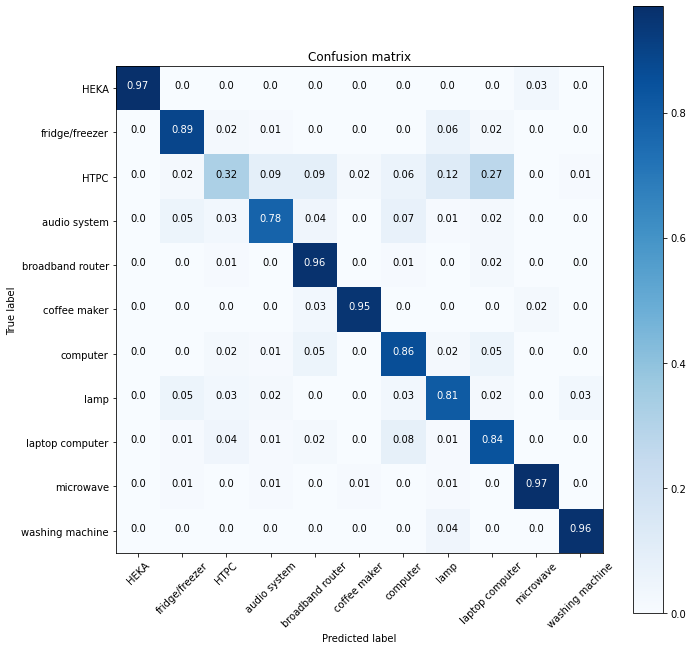

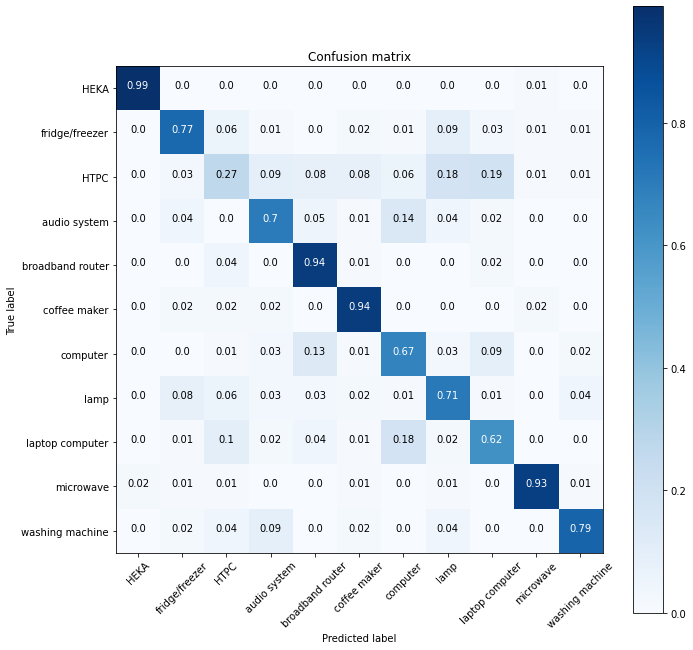

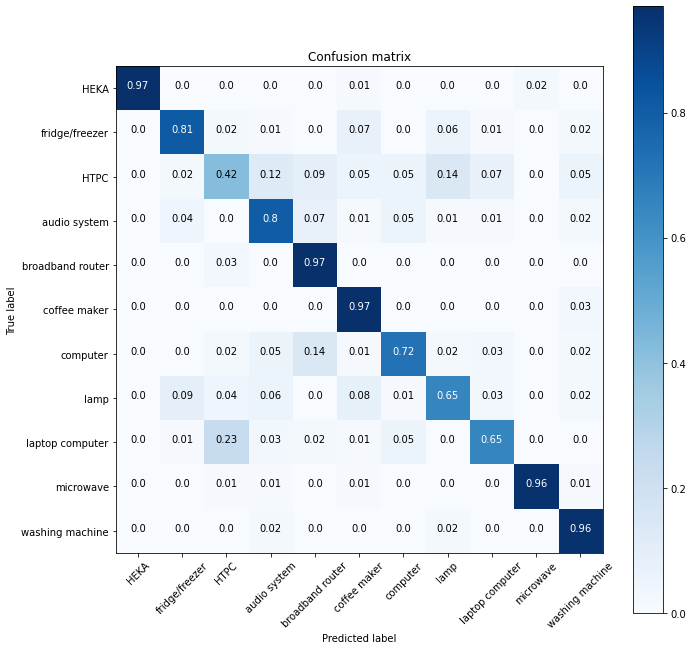

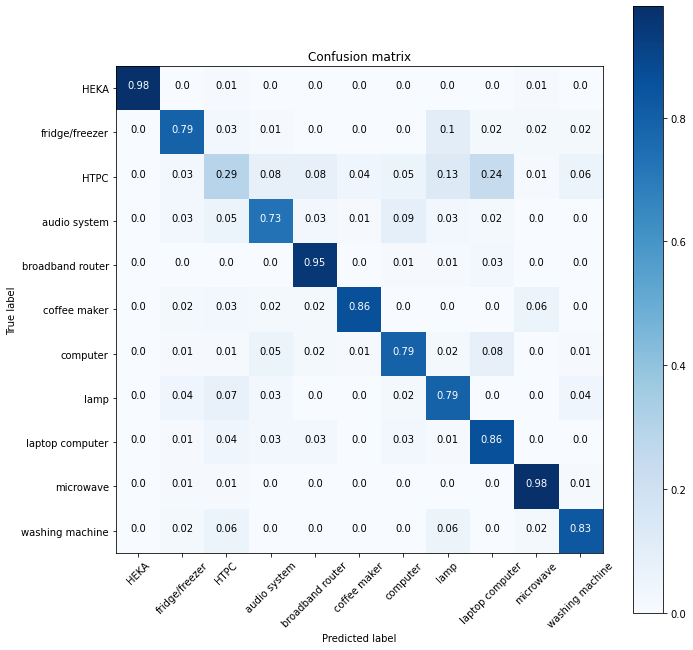

In [15]:
# datasets =[
#     "ukdale_gen_GASF_13m_100S5X12A54480_R82_80-20"
# ]

if environ['train_type'] == "TL": 
    models = environ['tl_datasets'].replace(" ","").split(",")
    #model = ["base"]
    
    for model in models:
    
        file_name = dataset
        
        datasetTL = model
        
        seed = dataset.split("_R")[1][0:2]
        
        print("using dataset data",dataset.split("_")[0],"training on model",model,"seed",environ['seed'])
        txt_log.write("starting "+dataset.split("_")[0]+" training on model "+model+" seed "+environ['seed']+"\n")


        tf.keras.backend.clear_session()


        #read the file
        path = str(pathlib.Path().resolve())
        path_data = f"{path}""/data/"f"{file_name}""/"f"{file_name}"".hdf5"
        file = h5py.File(path_data,"r+")


        print("reading data, printing stats: ")
        x_test,y_test,d_class_weights,num_of_classes,appliances = get_data(file)
        print("loading model")
        
        model_seed = 42
        model_used = create_tl_model(model,environ['learn_type'],model_seed,path,num_of_classes)
                
        train_gen = HDF5ImageGenerator(
            src= path_data,
            X_key="data/train/gaf",
            y_key="labels/train/gaf",
            classes_key="appliances/classes",
            labels_encoding="hot",
            shuffle=True,
            batch_size=int(environ['batch_size']),
            num_classes=num_of_classes,
            mode="train",
            )

        model_used.fit(
            train_gen,
            verbose=2,
            epochs=int(environ['epochs']),
            class_weight=d_class_weights,
            callbacks = [save_op_callback]
            #workers = 6,
        )
        
        txt_log.write("finished "+dataset.split("_")[0]+" training on model "+model+" seed "+environ['seed']+"\n")


        evaluate_model(model_used,x_test,y_test,appliances)
        



        #del model_used



In [16]:
txt_log.close()